In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from collections import Counter
import seaborn as sns

## Read data

In [2]:
df = pd.read_csv('orders.csv')
df

,item
0,"sugar, coffee"
1,"beans, ketchup"
2,sugar
3,coffee
4,"sugar, coffee"
5,"sugar, coffee"
6,"sugar, coffee"
7,"beans, ketchup"
8,"beans, ketchup"
9,beans


In [3]:
# Filter out single-item orders
df = df[df["item"].str.split(", ").str.len() > 1].reset_index(drop=True)
df

,item
0,"sugar, coffee"
1,"beans, ketchup"
2,"sugar, coffee"
3,"sugar, coffee"
4,"sugar, coffee"
5,"beans, ketchup"
6,"beans, ketchup"
7,"sugar, coffee, ketchup"
8,"sugar, ketchup"
9,"beans, ketchup"


In [4]:
# Create lists from each row
df["item"] = df["item"].str.split(", ")
df

,item
0,"[sugar, coffee]"
1,"[beans, ketchup]"
2,"[sugar, coffee]"
3,"[sugar, coffee]"
4,"[sugar, coffee]"
5,"[beans, ketchup]"
6,"[beans, ketchup]"
7,"[sugar, coffee, ketchup]"
8,"[sugar, ketchup]"
9,"[beans, ketchup]"


## Count occurrences of items

In [5]:
# Count occurrences of items in pairs
item_counts = df["item"].explode().value_counts()
item_counts

item
sugar      9
ketchup    9
coffee     8
beans      7
Name: count, dtype: int64

## Create pairs

<img src="pics/comb.png" style="width: 30%">

In [6]:
# Create all possible pairs from each row
pairs = []
for items in df["item"]:
    pairs.extend(itertools.combinations(sorted(items), 2))
pairs

[('coffee', 'sugar'),
 ('beans', 'ketchup'),
 ('coffee', 'sugar'),
 ('coffee', 'sugar'),
 ('coffee', 'sugar'),
 ('beans', 'ketchup'),
 ('beans', 'ketchup'),
 ('coffee', 'ketchup'),
 ('coffee', 'sugar'),
 ('ketchup', 'sugar'),
 ('ketchup', 'sugar'),
 ('beans', 'ketchup'),
 ('coffee', 'sugar'),
 ('beans', 'coffee'),
 ('beans', 'ketchup'),
 ('beans', 'sugar'),
 ('coffee', 'ketchup'),
 ('coffee', 'sugar'),
 ('ketchup', 'sugar'),
 ('coffee', 'sugar'),
 ('beans', 'ketchup'),
 ('beans', 'ketchup')]

## Pair occurrence

In [7]:
# Count the pairs occurence
pair_counts = Counter(pairs)

# Results
df_pair = pd.DataFrame(pair_counts.items(), columns=["pair", "count"]).sort_values("count", ascending=False)
df_pair

,pair,count
0,"(coffee, sugar)",8
1,"(beans, ketchup)",7
3,"(ketchup, sugar)",3
2,"(coffee, ketchup)",2
4,"(beans, coffee)",1
5,"(beans, sugar)",1


## Conditional probability

<img src='pics/eq-3.png' style="width: 50%">

In [8]:
# Total occurrences of pairs
total_orders = len(df)

# Calculate conditional probabilities for each pair
conditional_probs = []
for index, row in df_pair.iterrows():
    pair = row['pair']
    pair_count = row['count']
    
    # Calculate joint probability P(A ∩ B)
    joint_prob = pair_count / total_orders
    
    # Calculate marginal probability for the second item in the pair (e.g., sugar)
    item_prob = item_counts[pair[1]] / total_orders
    
    # Calculate conditional probability P(A | B) = P(A ∩ B) / P(B)
    conditional_prob = joint_prob / item_prob
    conditional_probs.append(conditional_prob)

df_pair['conditional_prob'] = conditional_probs
df_pair

,pair,count,conditional_prob
0,"(coffee, sugar)",8,0.888889
1,"(beans, ketchup)",7,0.777778
3,"(ketchup, sugar)",3,0.333333
2,"(coffee, ketchup)",2,0.222222
4,"(beans, coffee)",1,0.125000
5,"(beans, sugar)",1,0.111111


## Heatmap

In [9]:
# Extract unique items
unique_items = sorted(set(item for pair in df_pair['pair'] for item in pair))

# Create an empty matrix
matrix = pd.DataFrame(0, index=unique_items, columns=unique_items, dtype=float)

# Populate the matrix with conditional probabilities
for (item1, item2), prob in zip(df_pair['pair'], df_pair['conditional_prob']):
    matrix.loc[item1, item2] = prob
    matrix.loc[item2, item1] = prob

matrix

,beans,coffee,ketchup,sugar
beans,0.000000,0.125000,0.777778,0.111111
coffee,0.125000,0.000000,0.222222,0.888889
ketchup,0.777778,0.222222,0.000000,0.333333
sugar,0.111111,0.888889,0.333333,0.000000


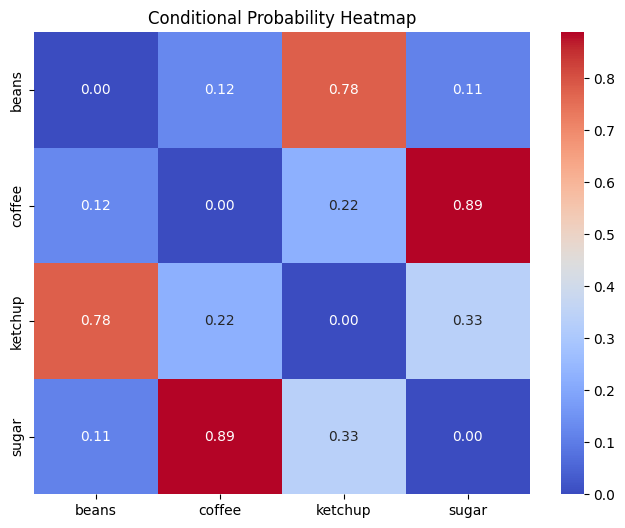

In [10]:
# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title('Conditional Probability Heatmap')
plt.show()